# This notebook deal with uncalibrated cosmic standard rulers and candles

In [2]:
#Show plots inline, and load main getdist plot module and samples class
### Need to run the following twice for some unknown reason. Otherwise plot wouldn't show
from __future__ import print_function
from IPython.display import display, Math
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples, loadMCSamples
import getdist, IPython
import pylab as plt
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
#matplotlib 2 doesn't seem to work well without usetex on
plt.rcParams['text.usetex']=True
import numpy as np
import WLbackground_cosmic_stds as BG
import WLlikelihoods_cosmic_stds as LIKE
import scipy.optimize as op
import emcee
from scipy import integrate
import time
from matplotlib import ticker, cm, patches, pyplot
import pandas as pd


GetDist Version: 1.1.2, Matplotlib version: 3.2.2


# Loading SNIa data:

In [ ]:
pantheon_path='Pantheon_data/lcparam_full_long_zhel.txt'
pantheon0 = pd.read_csv(pantheon_path, sep=" ", header=0)
pantheon = pantheon0[['name','zcmb','mb','dmb']]
pantheon = pantheon.sort_values(by='zcmb')    # sort SNIa in a z-ascending order for the new algorithm
pantheon = pantheon.reset_index()             # have to reset the index, otherwise the index is not sorted

Npan = len(pantheon.zcmb)   # number of all SN
z_obs = pantheon.zcmb       # redshift
m_obs = pantheon.mb         # apparent magnitude
dm_obs = pantheon.dmb       # uncertainty of m

pan_sys=np.loadtxt("Pantheon_data/sys_full_long_sort.txt")   # systematic errors, pre-sorted

C_pan = pan_sys+np.diag(pantheon.dmb**2) # total errros, including statistic and systematic errors

# Moore-Penrose pseudo-inverse
invC_pan = np.linalg.inv(C_pan)    # CHECK! In case the inverse doesn't work

# Best fits to SNIa data:

In [ ]:
start_time = time.time()

nll = lambda *args: -LIKE.lnprob_SN(*args)   # load likelihood
use_fast = True      # use fast likelihood or not       
SN_data = pantheon
invC = invC_pan

result = op.minimize(nll, [24, 0.3], args=(SN_data,invC,use_fast))
MH0_best = result["x"][0]     # MH0=M-5log10(10pc*H0)  #c=1, this is the same as C in the likelihood functions
# MH0 here is a combination of H0 and the absolute magnitude shifted to zero color and zero strecth. 
Om_best = result["x"][1]
print("Best fits: %2.6f, %1.7f" % (MH0_best, Om_best))

print("--- %s seconds ---" % (time.time() - start_time))

# MCMC to SNIa likelihood:
# In LCDM, SNIa likelihood has two parameters: MH0, Om

In [ ]:
# Run the above best fits first:

ndim, nwalkers, nstep = 2, 32, 500  # settings for emcee
use_fast = True   # use the fast likelihood or not
SN_data = pantheon
invC = invC_pan

# set the path/file to save the chain:
save_chain_file = 'chains/Fast1_walkers'+str(nwalkers)+'_step'+str(nstep)+'.csv'
    
# MCMC 
pos = [[MH0_best*(1+0.0004*np.random.randn()),Om_best*(1+0.01*np.random.randn())] for i in range(nwalkers)]

sampler_SN=emcee.EnsembleSampler(nwalkers, ndim, LIKE.lnprob_SN, args=(SN_data,invC,use_fast))
sampler_SN.run_mcmc(pos, nstep, progress=True,);

samples_SN = sampler_SN.chain[:, 50:, :].reshape((-1, ndim))   #filter out first XXX rows

np.savetxt(save_chain_file, samples_SN, delimiter=',')

# Caculate summary statistics to SN likelihood:

In [ ]:
load_chain_file = save_chain_file  # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")

# Saving Median and upper and lower limits
MH0_median_low_high, Om_median_low_high = map(lambda v: ((v[1], v[2]-v[1], v[1]-v[0])), 
                           zip(*np.percentile(samples, [16, 50, 84], axis=0))) # median + upper - lower
    
# Saving means and uncertainty
MH0_mean, Om_mean = np.mean(samples,axis=0)
MH0_std, Om_std = np.std(samples,axis=0)
    
print('Median+upper-lower:')
# display median + upper -lower of C
for MEDIAN, PARAM in zip([MH0_median_low_high, Om_median_low_high], 
                         ['M-5\log_{10}(10{\\rm{pc}}\\times H_0)','\Omega_{\mathrm{m}}']):
    txt = "{3} = {{{0: 2.3f}}}^{{+{1: .3f}}}_{{-{2: .3f}}}"
    txt = txt.format(MEDIAN[0], MEDIAN[1], MEDIAN[2], PARAM)
    display(Math(txt))

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip([MH0_mean, Om_mean], [MH0_std, Om_std],
                            ['M-5\log_{10}(10{\\rm{pc}}\\times H_0)', '\Omega_{\mathrm{m}}']):
    txt = "{2} = {0: 2.3f}\pm{1: .3f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

In [ ]:
names = [r'MH0', 'Omegam']    # put parameters here
labels =  [r'$M-5\log_{10}(10{\rm{pc}}\times H_0)$',r'$\Omega_m$']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels)
g = plots.getSinglePlotter(width_inch=5, ratio=1)
g.triangle_plot(MCsamples, ['MH0','Omegam'],shaded=True)
g.export(os.path.join(r'figures',r'pantheon_C_Om.pdf'))

# BAO data likelihood

# Best fit to BAO

In [51]:
start_time = time.time()

nll = lambda *args: -LIKE.lnprob_BAO(*args)   # load likelihood
BAO_data_path='BAO_data/'
BAO_datasets = ['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR14p845']

result = op.minimize(nll, [0.034, 0.3], args=(BAO_data_path,BAO_datasets))
rdH0_best = result["x"][0]     # MH0=M-5log10(10pc*H0)  #c=1, this is the same as C in the likelihood functions
# MH0 here is a combination of H0 and the absolute magnitude shifted to zero color and zero strecth. 
Om_best = result["x"][1]
print("Best fits: %2.6f, %1.7f" % (rdH0_best, Om_best))

print("--- %s seconds ---" % (time.time() - start_time))

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Best fits: 0.033743, 0.2944976
--- 0.43384289741516113 seconds ---


# MCMC to BAO:
# Late-time BAO has two parameters: rdH0 and Om

In [52]:
# Run the above best fits first:

ndim, nwalkers, nstep = 2, 64, 2000  # settings for emcee
BAO_data_path='BAO_data/'
BAO_datasets = ['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR14p845']

# set the path/file to save the chain:
save_chain_file_BAO = 'chains/BAO_only/BAO_walkers'+str(nwalkers)+'_step'+str(nstep)+'.csv'
    
# MCMC 
pos = [[rdH0_best*(1+0.01*np.random.randn()),Om_best*(1+0.06*np.random.randn())] for i in range(nwalkers)]

sampler_BAO=emcee.EnsembleSampler(nwalkers, ndim, LIKE.lnprob_BAO, args=(BAO_data_path,BAO_datasets))
sampler_BAO.run_mcmc(pos, nstep, progress=True,);
samples_BAO = sampler_BAO.chain[:, 50:, :].reshape((-1, ndim))   #filter out first XXX rows

np.savetxt(save_chain_file_BAO, samples_BAO, delimiter=',')

100%|██████████| 2000/2000 [06:27<00:00,  5.16it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'chains/BAO/BAO_walkers64_step2000.csv'

# Calculate Summary statistics:

In [56]:
load_chain_file = save_chain_file_BAO  # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")

# Saving Median and upper and lower limits
rdH0_median_low_high, Om_median_low_high = map(lambda v: ((v[1], v[2]-v[1], v[1]-v[0])), 
                           zip(*np.percentile(samples, [16, 50, 84], axis=0))) # median + upper - lower
    
# Saving means and uncertainty
rdH0_mean, Om_mean = np.mean(samples,axis=0)
rdH0_std, Om_std= np.std(samples,axis=0)
    
print('Median+upper-lower:')
# display median + upper -lower of rdH0
for MEDIAN, PARAM in zip([rdH0_median_low_high, Om_median_low_high], ['r_{\\rm{d}}H_0',
                                                                     '\Omega_{\mathrm{m}}']):
    txt = "{3} = {{{0: 2.4f}}}^{{+{1: .4f}}}_{{-{2: .4f}}}"
    txt = txt.format(MEDIAN[0], MEDIAN[1], MEDIAN[2], PARAM)
    display(Math(txt))

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip([rdH0_mean, Om_mean], [rdH0_std, Om_std], [' r_{\\rm{d}}H_0', '\Omega_{\mathrm{m}}']):
    txt = "{2} = {0: 2.5f}\pm{1: .5f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

Median+upper-lower:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mean+-uncertainty:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Plotting BAO MCMC:

In [ ]:
names = [r'rdH0', 'Omegam']    # put parameters here
labels =  [r'$r_{\rm{d}}H_0$',r'$\Omega_m$']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels)
g = plots.getSinglePlotter(width_inch=5, ratio=1)
g.triangle_plot(MCsamples, names, shaded=True)
g.export(os.path.join(r'figures',r'BAO_rdH0_Om.pdf'))

# CMB theta:
# This has three parameters: z_re, rsH0, Om

In [ ]:
# MCMC to CMB theta alone

ndim, nwalkers, nstep = 3, 32, 400  # settings for emcee
CMB_means = np.loadtxt('CMB_theta/CMB_theta_means.txt') # z_re, theta (R optional)
CMB_Cov = np.loadtxt('CMB_theta/CMB_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)

# set the path/file to save the chain:
save_chain_file = 'CMB_theta/chains/CMB_walkers'+str(nwalkers)+'_step'+str(nstep)+'.csv'

    
# MCMC 
pos = [[1089*(1+0.001*np.random.randn()),
        0.03307*(1+0.01*np.random.randn()),0.3*(1+0.01*np.random.randn())] for i in range(nwalkers)]

sampler_CMB=emcee.EnsembleSampler(nwalkers, ndim, LIKE.lnprob_CMB, args=(CMB_means,CMB_invC))
sampler_CMB.run_mcmc(pos, nstep, progress=True,);
samples_CMB = sampler_CMB.chain[:, 50:, :].reshape((-1, ndim))   #filter out first XXX rows

np.savetxt(save_chain_file, samples_CMB, delimiter=',')

In [ ]:
load_chain_file = save_chain_file  # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")
names = ['zstar','rsH0', 'Omegam']    # put parameters here
labels =  [r'$z_*$',r'$r_{\rm{s}}H_0$',r'$\Omega_m$']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels)
g = plots.getSinglePlotter(width_inch=5, ratio=1)
g.plot_2d([MCsamples], 'rsH0', 'Omegam', shaded=True)
g.export(os.path.join(r'figures',r'CMB_rsH0_Om.pdf'))

# Combined analysis:

In [ ]:
# load SN data
pantheon_path='Pantheon_data/lcparam_full_long_zhel.txt'
pantheon0 = pd.read_csv(pantheon_path, sep=" ", header=0)
pantheon = pantheon0[['name','zcmb','mb','dmb']]
pantheon = pantheon.sort_values(by='zcmb')    # sort SNIa in a z-ascending order for the new algorithm
pantheon = pantheon.reset_index()             # have to reset the index, otherwise the index is not sorted
Npan = len(pantheon.zcmb)   # number of all SN
pan_sys=np.loadtxt("Pantheon_data/sys_full_long_sort.txt")   # systematic errors
C_pan = pan_sys+np.diag(pantheon.dmb**2) # including systematic errors
invC_pan = np.linalg.inv(C_pan)

# load BAO data
#BAO_data_path='BAO_data/'
#BAO_datasets = ['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR14p845']

# load CMB theta
CMB_means = np.loadtxt('CMB_theta/CMB_theta_means.txt')
CMB_Cov = np.loadtxt('CMB_theta/CMB_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)

In [ ]:
# Define the combined likelihoods

def lnprior_combined(theta): # keep the order of theta to be zstar, rsH0, MH0, Om, h, DeltarH0, m_v1
    if len(theta)==6:
        if 1070<theta[0]<1120 and 0.01<theta[1]<0.1 and 17<theta[2]<30 and 0.01<theta[3]<0.99 and 0.55<theta[4]<0.88 and 5.E-4<theta[5]<7.E-4:
            return 0.0
    if len(theta)==7:
        if 1070<theta[0]<1120 and 0.01<theta[1]<0.1 and 17<theta[2]<30 and 0.01<theta[3]<0.99 and 0.55<theta[4]<0.88 and 5.E-4<theta[5]<7.E-4 and 0.0002<theta[5]<1.0:
            return 0.0
    return -np.inf

def lnprob_stds(theta,SN_input,BAO_input,CMB_input,CC_input):
    SN_data, invC = SN_input   # use fast SN likelihood by default
    BAO_data_path, BAO_datasets = BAO_input
    CMB_means, CMB_invC = CMB_input
    use_CC,CC_path = CC_input
    if len(theta)==6:
        zstar_fit, rsH0_fit, MH0_fit, Om_fit, h_fit, DeltarH0_fit = theta
        m_v1_fit=0.0
        #rdH0_derived = rsH0_fit+BG.Delta_rH0(zstar_fit,29.98,Om_fit,h_fit) 
        # Deltaz is set to be 29.98, need further consideration
        rdH0_derived = rsH0_fit+DeltarH0_fit # used a prior on Deltar instead
        theta_SN = [MH0_fit, Om_fit, h_fit]
        theta_BAO = [rdH0_derived, Om_fit, h_fit]
        theta_CMB = [zstar_fit, rsH0_fit, Om_fit, h_fit]
    if len(theta)==7:
        zstar_fit, rsH0_fit, MH0_fit, Om_fit, h_fit, DeltarH0_fit, m_v1_fit = theta
        #rdH0_derived = rsH0_fit+BG.Delta_rH0(zstar_fit,29.98,Om_fit,h_fit,m_v1_fit)
        rdH0_derived = rsH0_fit+DeltarH0_fit # used a prior on DeltarH0 instead
        theta_SN = [MH0_fit, Om_fit, h_fit, m_v1_fit]
        theta_BAO = [rdH0_derived, Om_fit, h_fit, m_v1_fit]
        theta_CMB = [zstar_fit, rsH0_fit, Om_fit, h_fit, m_v1_fit]
        
    lp = lnprior_combined(theta)
    if not np.isfinite(lp):
        return -np.inf
    lp += LIKE.lnlike_SN_fast(theta_SN, SN_data, invC)
    lp += LIKE.lnlike_BAO(theta_BAO, BAO_data_path, BAO_datasets)
    lp += LIKE.lnlike_CMB(theta_CMB, CMB_means, CMB_invC)
    lp += -0.5*(DeltarH0_fit-5.9707175E-4)**2/(1E-5)**2  # some model insensitive prior on Deltar 
    
    if use_CC==True:
        chronometers = np.loadtxt(CC_path)
        Hz = BG.Hz(chronometers[:,0], h_fit*100, Om_fit)
        lp += -0.5*(np.sum((Hz-chronometers[:,1])**2/chronometers[:,2]**2))
        
    return lp
    

In [64]:
# This is the define treatment
# Define the default combined likelihoods 

def lnprob_stds_default(theta,SN_input,BAO_input,CMB_input,CC_input):
    SN_data, invC = SN_input   # use fast SN likelihood by default
    BAO_data_path, BAO_datasets = BAO_input
    CMB_means, CMB_invC, Deltazrec_obs, dDeltazrec_obs = CMB_input
    use_CC,CC_path = CC_input
    zstar_fit, rsH0_fit, MH0_fit, Om_fit, h_fit, Deltazrec, omegabh2 = theta
    m_v1_fit=0.0  # normal hierachy, lowest mass =0 
    
    lp = 0.0
    # priors: keep the order of theta to be zstar, rsH0, MH0, Om, h, Deltazrec, omegabh2
    if not (1070<theta[0]<1120 and 0.01<theta[1]<0.1 and 17<theta[2]<30 and \
              0.01<theta[3]<0.99 and 0.6<theta[4]<0.8 and \
              20<theta[5]<40 and 0.01<theta[6]<0.04):
        return -np.inf
    rdH0_derived = rsH0_fit+BG.Delta_rH0(zstar_fit,Deltazrec,Om_fit,h_fit,omegabh2) 
    lp += -0.5*(Deltazrec-Deltazrec_obs)**2/(dDeltazrec_obs)**2  
    lp += -0.5*(omegabh2-0.0222)**2/0.0005**2
    
    theta_SN = [MH0_fit, Om_fit, h_fit]
    theta_BAO = [rdH0_derived, Om_fit, h_fit]
    theta_CMB = [zstar_fit, rsH0_fit, Om_fit, h_fit]
   
    lp += LIKE.lnlike_SN_fast(theta_SN, SN_data, invC)
    lp += LIKE.lnlike_BAO(theta_BAO, BAO_data_path, BAO_datasets)
    lp += LIKE.lnlike_CMB(theta_CMB, CMB_means, CMB_invC)
    
    if use_CC==True:
        chronometers = np.loadtxt(CC_path)
        Hz = BG.Hz(chronometers[:,0], h_fit*100, Om_fit)
        lp += -0.5*(np.sum((Hz-chronometers[:,1])**2/chronometers[:,2]**2))
        
    return lp
    

# Combined MCMC

# Use default treatment on the difference of sound horizon:

In [149]:
ndim, nwalkers, nstep = 7, 64, 3000  # settings for emcee
# set the path/file to save the chain:
save_chain_file = 'chains/Default/ACTtheta_BAO/All_BAO_butconsensus_SN_'+str(nwalkers)+'_step'+str(nstep)+'.csv'

SN_input=[pantheon,invC_pan]
BAO_input= ['BAO_data/',['6df','DR7_MGS','DR14p845','DR14_qsar','DR14_lya_qsar']]
CMB_means = np.loadtxt('CMB_theta/ACT_theta_means.txt') # z_re, theta (R optional)
CMB_Cov = np.loadtxt('CMB_theta/ACT_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)
# some model insensitive prior on Dltazrec 
# 3.0025609E+01+-5.4452421E-01 for Planck
# 2.9952195E+01+-7.5056623E-01 for ACT+WMAP
CMB_input= [CMB_means,CMB_invC,2.9952195E+01,7.5056623E-01]
CC_input=[False,'./CC_data/CC_with_ExtraError.txt']
# MCMC 
pos = [[1089.0*(1+0.0002*np.random.randn()),   # z_rec
        0.033*(1+0.0005*np.random.randn()),    # rsH0
        23.809306*(1+0.0003*np.random.randn()),   # MH0
        0.3*(1+0.0003*np.random.randn()),         # Omegam
        0.7*(1+0.002*np.random.randn()),          # h
        30*(1+0.002*np.random.randn()),           # Deltaz_decoupling
        0.0222*(1+0.002*np.random.randn())] for i in range(nwalkers)]       # omegabh2

sampler_combined=emcee.EnsembleSampler(nwalkers, ndim, lnprob_stds_default, 
                                       args=(SN_input,BAO_input,CMB_input,CC_input))
sampler_combined.run_mcmc(pos, nstep, progress=True,);
samples_combined = sampler_combined.chain[:, 100:, :].reshape((-1, ndim))   #filter out first XXX rows
np.savetxt(save_chain_file, samples_combined, delimiter=',')

100%|██████████| 3000/3000 [59:36<00:00,  1.19s/it] 


In [ ]:
load_chain_file = save_chain_file  # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")

# Saving Median and upper and lower limits
zstar_medianstat,rsH0_medianstat,MH0_medianstat,Om_medianstat,h_medianstat,\
            Deltazrec_mediansta, omegabh2_medianstat = map(lambda v: ((v[1], \
            v[2]-v[1], v[1]-v[0])), zip(*np.percentile(samples, [16, 50, 84], axis=0))) # median + upper - lower
    
# Saving means and uncertainty
zstar_mean,rsH0_mean,MH0_mean,Om_mean,h_mean,Deltazrec_mean,omegabh2_mean = np.mean(samples,axis=0)
zstar_std,rsH0_std,MH0_std,Om_std,h_std,Deltazrec_mean,omegabh2_mean = np.std(samples,axis=0)
    
print('Median+upper-lower:')
# display median + upper -lower of rdH0
for MEDIAN, PARAM in zip([Om_medianstat,h_medianstat], ['\Omega_{\mathrm{m}}','h']):
    txt = "{3} = {{{0: 2.4f}}}^{{+{1: .4f}}}_{{-{2: .4f}}}"
    txt = txt.format(MEDIAN[0], MEDIAN[1], MEDIAN[2], PARAM)
    display(Math(txt))

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip([Om_mean,h_mean], [Om_std,h_std], ['\Omega_{\mathrm{m}}','h']):
    txt = "{2} = {0: 2.3f}\pm{1: .3f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

In [ ]:
load_chain_file = save_chain_file # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")
names = ['zstar','rsH0', 'MH0','omegam','h','Deltazrec','omegabh2']    # put parameters here
labels =  [r'z_*',r'r_{\rm{s}}H_0',r'\mathcal{M}',r'\Omega_m',r'h',r'\Delta z_{dec}','\Omega_b h^2']
MCsamples = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(0.55, 0.88)},
                      label='Uncalibrated Cosmic Standards')
p = MCsamples.getParams() 
MCsamples.addDerived(p.h*100, name='H0', label=r'$H_0$',range=[55,88])
Delta_rH0s=[]
for xa,xb,xc,xd,xe in zip(p.zstar,p.Deltazrec,p.omegam,p.h,p.omegabh2):
     Delta_rH0s.append(BG.Delta_rH0(xa,xb,xc,xd,xe))  
MCsamples.addDerived(np.array(Delta_rH0s),name='DeltarsH0', label=r'$\Delta r_sH_0$')
g = plots.getSinglePlotter(width_inch=8, ratio=1)
g.triangle_plot(MCsamples, ['rsH0', 'MH0','omegam'] , shaded=True)
g.export(os.path.join(r'figures',r'Combined.pdf'))

In [ ]:
PathExtra='/Users/weikanglin/Documents/Documents NCSU/Projects/3STDs/chains_new/'
g = plots.getSinglePlotter(width_inch=5, ratio=0.8)
g.settings.alpha_filled_add=0.5
#g.add_y_bands(0.298, 0.022, alpha1=0.2,alpha2=0.2,color='grey',zorder=1)
g.add_x_bands(74.03, 1.42, alpha1=0.4,alpha2=0.2, color='yellow',zorder=1) 
#g.add_x_bands(69.6, 1.88, alpha1=0.3,alpha2=0.23, color='pink',zorder=1) 
g.plot_2d([MCsamples], 'H0', 'omegam',filled=True,zorder=2)
g.add_2d_contours(PathExtra+'base_plikHM_TTTEEE_lowl_lowE', 'H0', 'omegam',
                  filled=True, color='k');

H0_range=np.arange(55,88,0.1)
Om_up1=(0.298+0.010236796512)+(H0_range-70)*0.00014
Om_low1=(0.298-0.010236796512)+(H0_range-70)*0.00014
plt.plot(H0_range,Om_up1,color='red')
plt.plot(H0_range,Om_low1,color='red')

g.set_axes(lims=[60, 80, 0.265, 0.345])
g.export(os.path.join(r'figures',r'Compare_UCstds.pdf'))

# Run CMB theta + individual BAO:

In [5]:
ndim, nwalkers, nstep = 7, 64, 3000  # settings for emcee

# SN input:
pantheon_path='Pantheon_data/lcparam_full_long_zhel.txt'
pantheon0 = pd.read_csv(pantheon_path, sep=" ", header=0)
pantheon = pantheon0[['name','zcmb','mb','dmb']]
pantheon = pantheon.sort_values(by='zcmb')    # sort SNIa in a z-ascending order for the new algorithm
pantheon = pantheon.reset_index()             # have to reset the index, otherwise the index is not sorted
Npan = len(pantheon.zcmb)   # number of all SN
pan_sys=np.loadtxt("Pantheon_data/sys_full_long_sort.txt")   # systematic errors
C_pan = pan_sys+np.diag(pantheon.dmb**2) # including systematic errors
invC_pan = np.linalg.inv(C_pan)
SN_input=[pantheon,invC_pan]

# BAO input:
BAO_input= ['BAO_data/',['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR14p845']]
CMB_means = np.loadtxt('CMB_theta/ACT_theta_means.txt') # z_re, theta (R optional) ### ！！！！！

# CMB theta input
CMB_Cov = np.loadtxt('CMB_theta/ACT_theta_Cov.txt')    ### ！！！！！
CMB_invC = np.linalg.inv(CMB_Cov)
# some model insensitive prior on Dltazrec 
# 3.0025609E+01+-5.4452421E-01 for Planck
# 2.9952195E+01+-7.5056623E-01 for ACT+WMAP
CMB_input= [CMB_means,CMB_invC,2.9952195E+01,7.5056623E-01]        ### ！！！！！
CC_input=[False,'./CC_data/CC_with_ExtraError.txt']

# MCMC 
for BAO_name in ['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR14p845']:
    BAO_input = ['BAO_data/',[BAO_name]]
    save_chain_file = 'chains/Default/ACTtheta_BAO/narrower_h/'+BAO_name+'_'+str(nwalkers)+'_step'+str(nstep)+'.csv'

    pos = [[1089.0*(1+0.0002*np.random.randn()),   # z_rec
        0.033*(1+0.0005*np.random.randn()),    # rsH0
        23.809306*(1+0.0003*np.random.randn()),   # MH0
        0.3*(1+0.001*np.random.randn()),         # Omegam
        0.7*(1+0.01*np.random.randn()),          # h
        30*(1+0.002*np.random.randn()),           # Deltaz_decoupling 3
        0.0222*(1+0.002*np.random.randn())] for i in range(nwalkers)]       # omegabh2

    sampler_combined=emcee.EnsembleSampler(nwalkers, ndim, lnprob_stds_default, 
                                       args=(SN_input,BAO_input,CMB_input,CC_input))
    sampler_combined.run_mcmc(pos, nstep, progress=True,);
    samples_combined = sampler_combined.chain[:, :, :].reshape((-1, ndim))   #filter out first XXX rows
    np.savetxt(save_chain_file, samples_combined, delimiter=',')

100%|██████████| 3000/3000 [05:30<00:00,  9.09it/s]


In [150]:
names = ['zstar','rsH0', 'MH0','omegam','h','Deltazrec','omegabh2']    # put parameters here
labels =  [r'z_*',r'r_{\rm{s}}H_0',r'\mathcal{M}',r'\Omega_m',r'h',r'\Delta z_{dec}','\Omega_b h^2']
Om_means={'Planck':[],'ACT+WMAP':[]}
Om_stds={'Planck':[],'ACT+WMAP':[]}
for BAO_name in ['6df','DR7_MGS','DR12_consensus','DR14p845','DR14_qsar',
                 'DR14_lya_qsar','All_BAO_butconsensus_SN','All_BAO_SN']:
    print(r'CMB+'+BAO_name)
    for prefix, path_name in zip(['Planck','ACT+WMAP'],['CMB','ACT']):
        load_chain_file = 'chains/Default/'+path_name+'theta_BAO/'+ \
                 BAO_name+'_'+str(nwalkers)+'_step'+str(nstep)+'.csv'
        samples = np.loadtxt(load_chain_file,delimiter=",")
        MCsamples = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(0.55, 0.88)},
                      label='Uncalibrated Cosmic Standards',ignore_rows=500)
        txt=prefix+': '+str(round(MCsamples.getMargeStats().parWithName('omegam').mean,4))+ \
                '\pm'+str(round(MCsamples.std('omegam'),4))
        display(Math(txt))
        Om_means[prefix].append(MCsamples.getMargeStats().parWithName('omegam').mean)
        Om_stds[prefix].append(MCsamples.std('omegam'))
        

CMB+6df


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CMB+DR7_MGS


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CMB+DR12_consensus


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CMB+DR14p845


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CMB+DR14_qsar


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CMB+DR14_lya_qsar


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CMB+All_BAO_butconsensus_SN


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CMB+All_BAO_SN


<IPython.core.display.Math object>

<IPython.core.display.Math object>

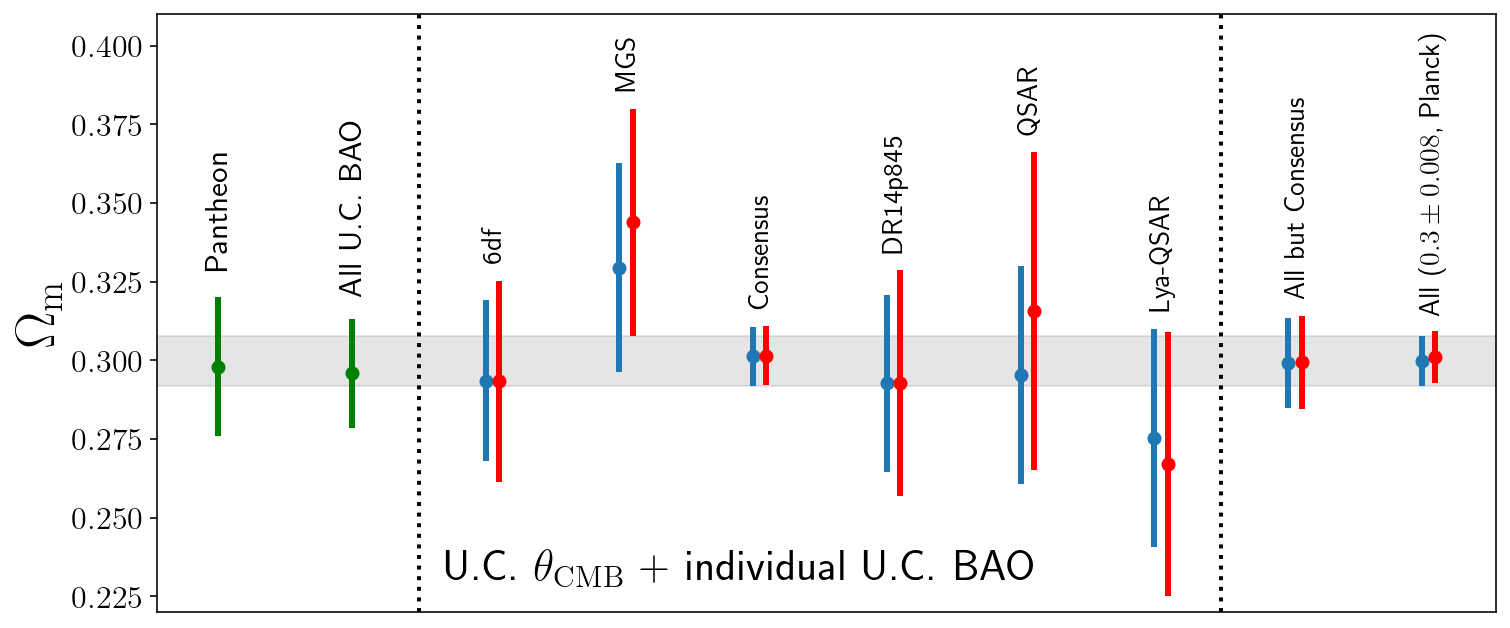

In [272]:
N_bao = len(Om_means['Planck'])
fig,ax = plt.subplots(figsize=((N_bao+2)*1.2,5.5))
plt.errorbar(-2,0.298,0.022,fmt='og',linewidth=3)
plt.errorbar(-1,0.29582,0.01729,fmt='og',linewidth=3) # All BAO
for prefix, offset, fmt,ls in zip(['Planck','ACT+WMAP'],[0,0.1],['o','or'],['-',':']):
    plt.errorbar(np.arange(N_bao)+offset,Om_means[prefix],Om_stds[prefix],fmt=fmt,linewidth=3)
plt.axvline(x=N_bao-2.5,linestyle=':',color='k',linewidth=2)
plt.axvline(x=-.5,linestyle=':',color='k',linewidth=2)
plt.ylabel(r'$\Omega_{\rm{m}}$',fontsize=28)
plt.yticks(fontsize=16)
plt.axhspan(Om_means['Planck'][-1]-Om_stds['Planck'][-1],
                  Om_means['Planck'][-1]+Om_stds['Planck'][-1],color='gray',alpha=0.2)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.text(-2.1, 0.33,'Pantheon',fontsize=16,rotation=90)
plt.text(-1.1, 0.322,'All U.C. BAO',fontsize=16,rotation=90)
plt.text(-.3, 0.23,r'U.C. $\theta_{\rm{CMB}}$ + individual U.C. BAO',fontsize=22)

for bao, i in zip(['6df','MGS','Consensus','DR14p845','QSAR',
                 'Lya-QSAR','All but Consensus','All'+r' ($'+str(round(Om_means['Planck'][i],3))
         +'\pm'+str(round(Om_stds['Planck'][i],3))+'$, Planck)'],np.arange(N_bao)):
    plt.text(i-0.03, max(Om_means['Planck'][i]+Om_stds['Planck'][i],
                        Om_means['ACT+WMAP'][i]+Om_stds['ACT+WMAP'][i])+0.007,bao,fontsize=14,rotation=90)

plt.ylim(0.22,0.41)
plt.savefig('figures/Constraints_Om.pdf', bbox_inches='tight')

# Use secondary treatment:

In [ ]:
ndim, nwalkers, nstep = 6, 64, 1000  # settings for emcee
# set the path/file to save the chain:
save_chain_file = 'chains/UCstds_'+str(nwalkers)+'_step'+str(nstep)+'.csv'

SN_input=[pantheon,invC_pan]
BAO_input= ['BAO_data/',['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR14p845']]
CMB_input= [CMB_means,CMB_invC]
CC_input=[False,'../3STDs/cosmic_chronometers_data/CC_with_ExtraError.txt']
# MCMC 
pos = [[1089.0*(1+0.0002*np.random.randn()),
        0.033*(1+0.0005*np.random.randn()),
        23.809306*(1+0.0003*np.random.randn()),
        0.3*(1+0.0003*np.random.randn()),
        0.7*(1+0.002*np.random.randn()),
        5.9707175E-4*(1+0.002*np.random.randn())] for i in range(nwalkers)]

sampler_combined=emcee.EnsembleSampler(nwalkers, ndim, lnprob_stds, args=(SN_input,BAO_input,CMB_input,CC_input))
sampler_combined.run_mcmc(pos, nstep, progress=True,);

samples_combined = sampler_combined.chain[:, 100:, :].reshape((-1, ndim))   #filter out first XXX rows

np.savetxt(save_chain_file, samples_combined, delimiter=',')

# Calculate Summary Statistics

In [ ]:
load_chain_file = save_chain_file  # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")

# Saving Median and upper and lower limits
zstar_medianstat,rsH0_medianstat,MH0_medianstat,Om_medianstat,h_medianstat,Deltar_medianstat = map(lambda v: ((v[1], 
            v[2]-v[1], v[1]-v[0])), zip(*np.percentile(samples, [16, 50, 84], axis=0))) # median + upper - lower
    
# Saving means and uncertainty
zstar_mean,rsH0_mean,MH0_mean,Om_mean,h_mean,Deltar_mean = np.mean(samples,axis=0)
zstar_std,rsH0_std,MH0_std,Om_std,h_std,Deltar_std = np.std(samples,axis=0)
    
print('Median+upper-lower:')
# display median + upper -lower of rdH0
for MEDIAN, PARAM in zip([Om_medianstat,h_medianstat], ['\Omega_{\mathrm{m}}','h']):
    txt = "{3} = {{{0: 2.4f}}}^{{+{1: .4f}}}_{{-{2: .4f}}}"
    txt = txt.format(MEDIAN[0], MEDIAN[1], MEDIAN[2], PARAM)
    display(Math(txt))

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip([Om_mean,h_mean], [Om_std,h_std], ['\Omega_{\mathrm{m}}','h']):
    txt = "{2} = {0: 2.3f}\pm{1: .3f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

In [ ]:
load_chain_file = save_chain_file # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")
names = ['zstar','rsH0', 'MH0','omegam','h','DeltarH0']    # put parameters here
labels =  [r'$z_*$',r'$r_{\rm{s}}H_0$',r'$\mathcal{M}$',r'$\Omega_m$',r'$h$',r'$\Delta r_sH_0$']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(0.55, 0.88)},
                      label='Uncalibrated Cosmic Standards')
p = MCsamples.getParams() 
MCsamples.addDerived(p.h*100, name='H0', label=r'$H_0$',range=[55,88])
g = plots.getSinglePlotter(width_inch=8, ratio=1)
g.triangle_plot(MCsamples, ['rsH0', 'MH0','omegam'] , shaded=True)
g.export(os.path.join(r'figures',r'Combined.pdf'))

In [ ]:
PathExtra='/Users/weikanglin/Documents/Documents NCSU/Projects/3STDs/chains_new/'
g = plots.getSinglePlotter(width_inch=5, ratio=0.8)
g.settings.alpha_filled_add=0.5
#g.add_y_bands(0.298, 0.022, alpha1=0.2,alpha2=0.2,color='grey',zorder=1)
g.add_x_bands(74.03, 1.42, alpha1=0.4,alpha2=0.2, color='yellow',zorder=1) 
#g.add_x_bands(69.6, 1.88, alpha1=0.3,alpha2=0.23, color='pink',zorder=1) 
g.plot_2d([MCsamples], 'H0', 'omegam',filled=True,zorder=2)
g.add_2d_contours(PathExtra+'base_plikHM_TTTEEE_lowl_lowE', 'H0', 'omegam',
                  filled=True, color='k');

H0_range=np.arange(55,88,0.1)
Om_up1=(0.300322+0.010236796512)+(H0_range-70.579829)*0.0002
Om_low1=(0.300322-0.010236796512)+(H0_range-70.579829)*0.0002
plt.plot(H0_range,Om_up1,color='red')
plt.plot(H0_range,Om_low1,color='red')

g.set_axes(lims=[60, 80, 0.265, 0.345])
g.export(os.path.join(r'figures',r'Compare_UCstds.pdf'))

In [ ]:
print(MCsamples.PCA(['omegam','H0'],param_map=['N','N']))

In [ ]:
PC1_mean=(1.014188*0.70833402)**(-1/5.172426)*0.299618
PC1_std=PC1_mean*(0.170617/1.014188)/5.172426
print(PC1_mean,PC1_std)

In [ ]:
0.000888*11.527924

# Belows are some preliminary results for LSS

In [ ]:
tempdir='/Users/weikanglin/Documents/Documents NCSU/Projects/3STDs/chains_LSS/DES_withBBN'
g = plots.getSinglePlotter(chain_dir=tempdir,width_inch=7, ratio=0.8)
g.settings.alpha_filled_add=0.6
samples_DES = loadMCSamples(tempdir, settings={'ignore_rows':0.3}); 
g.plot_2d([samples_DES,MCsamples], 'H0', 'omegam',filled=True)

# preliminary:
#g.add_2d_covariance(np.array([72.4626984 ,  0.29842372]), 
#                    np.array([[4.68442296e+01, 1.10692999e-03],[1.10692999e-03, 6.61706597e-05]]),
#                    filled=True, color='g',alpha=0.75)

g.add_legend(['DES','Uncalibrated Cosmic Standards', 'Preliminary Joint'])
g.set_axes(lims=[55, 85, 0.24, 0.36])


g.export(os.path.join(r'figures',r'Combined_h_Om_new.pdf'))

In [ ]:
# Saving Median and upper and lower limits
# Saving means and uncertainty

load_chain_file = save_chain_file # choose file to load
samples_all_rulers = np.loadtxt(load_chain_file,delimiter=",")
names = ['zstar','rsH0', 'MH0','omegam','h']    # put parameters here
labels =  [r'$z_*$',r'$r_{\rm{s}}H_0$',r'$MH_0$',r'$\Omega_m$',r'$h$']    # label parameters here
MCsamples_UCrulers = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(None, 2)},
                      label='Uncalibrated Standard Rulers')
p = MCsamples_UCrulers.getParams() 
MCsamples_UCrulers.addDerived(p.h*100, name='H0', label=r'$H_0$')

MEANS = np.mean(samples,axis=0)
ERRORS = np.std(samples,axis=0)
    
print('Median+upper-lower:')

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip(MEANS, ERRORS, [r'z_*',r'r_{\rm{s}}H_0',
                                            r'M-5\log_{10}(10{\rm{pc}}\times H_0)',r'\Omega_m',r'h']):
    txt = "{2} = {0: 2.4f}\pm{1: .4f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

In [ ]:
CMB_means = np.loadtxt('CMB_theta/CMB_theta_means.txt')
CMB_Cov = np.loadtxt('CMB_theta/CMB_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)

SN_input=[pantheon,invC_pan]
BAO_input= ['BAO_data/',['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar']]
CMB_input= [CMB_means,CMB_invC]
lnprob_stds([1089.9515,0.03243,23.809306,0.3,0.70],SN_input,BAO_input,CMB_input)